In [1]:
# Add imports
# Load the ushahidi dataset and print out first rows
# Perform text preprocessing - similar to what i did for the baseline classifiers - create clean text
# Train first XLM Roberta model and see how it perfroms
# Might try training all models this weekend, and then the next goal could be to see how to use the
import pandas as pd
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
import json
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import TweetTokenizer
import textwrap
import numpy as np
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
pd.set_option('display.max_colwidth',1000)
from itertools import cycle


# Wrap text to 80 characters.
wrapper = textwrap.TextWrapper(width=80, initial_indent='    ',
                               subsequent_indent='    ')
nltk.download('stopwords')
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load data
data = pd.read_csv('/content/drive/My Drive/thesis/combined_election_reports.csv', encoding='utf-8')

In [4]:
data.head(10)

,id,label,text,status,date,categories,latitude,longitude,Election Date
0,4.0,Polling Station Administration,https://twitter.com/1146124540055052289/status/1541417316273246208,published,2022-06-27 13:45:01,Polling station logistical issues,-1.303169,36.826061,August 2022
1,6.0,Polling Station Administration,https://twitter.com/1510781350902706180/status/1541412494526259202,archived,2022-06-27 13:25:51,Polling station logistical issues,-1.283253,36.817245,August 2022
2,634.0,Opinions,"Elections are coming. Youths should turn up,vote and Preach peace before, during and after the Elections. We can never be used and divided for selfish Political Interests.",published,2022-07-05 05:08:29,Peace messages,-1.283253,36.817245,August 2022
3,637.0,Opinions,"It is important for youths to understand the election and voting processes, their role in the processes and how to ensure that peace is maintained even after elections.",published,2022-07-05 05:16:28,Peace messages,-1.303264,36.826384,August 2022
4,641.0,Media Reports,"""More so this time, the media has deliberately done a good job in imparting skills on gender-sensitive reporting and boosting the coverage of women in the run up to the general election.""",published,2022-07-05 06:35:48,NaN,-1.283253,36.817245,August 2022
5,649.0,Opinions,Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities!,published,2022-07-05 07:19:47,Positive Opinions,-1.283253,36.817245,August 2022
6,650.0,Opinions,Let's all stand out as youth to be agents of change by spreading the message of peace across all the borders within Kenya. Make an impact. There is elections and life after elections.,published,2022-07-05 07:15:02,Peace messages,-1.283253,36.817245,August 2022
7,655.0,Opinions,https://twitter.com/96178520/status/1544239894113013761,published,2022-07-05 08:40:56,Positive Opinions,-1.283253,36.817245,August 2022
8,656.0,Opinions,Quite critical indeed @ItsKimaniThomas\nThe active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections.,published,2022-07-05 08:47:59,Neutral,-1.303264,36.826384,August 2022
9,657.0,Opinions,The active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections.,published,2022-07-05 08:56:36,Positive Opinions,-1.283253,36.817245,August 2022


In [5]:
data['text'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 128288 entries, 0 to 128287
Series name: text
Non-Null Count   Dtype 
--------------   ----- 
128288 non-null  object
dtypes: object(1)
memory usage: 1002.4+ KB


In [6]:
data.shape

(128288, 9)

Data Preprocessing

In [7]:
# Util functions for cleaning the data
def replace_newline(text):
    '''
        Replace all occurences of new line delimeter in the text with space
    '''
    cleaned_text = text.replace("\n", " ")
    return cleaned_text

# Remove unicode
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

# Replacing URLs
def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

# Replace user mentions e.g. @
def replaceAtUser(text):
    """ Replaces "@user" with "atUser" """
    text = re.sub('@[^\s]+','usr',text)
    return text

# Remove hashtags infront of words
def removeHashtagInFrontOfWord(text):
    """ Removes hastag in front of a word """
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

def replace_numbers(text):
    cleaned_text = re.sub(r'[0-9]', '', text)
    return cleaned_text

def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def replaceMultiExclamationMark(text):
    """ Replaces repetitions of exlamation marks """
    text = re.sub(r"(\!)\1+", ' multiExclamation ', text)
    return text

def replaceMultiQuestionMark(text):
    """ Replaces repetitions of question marks """
    text = re.sub(r"(\?)\1+", ' multiQuestion ', text)
    return text

def replaceMultiStopMark(text):
    """ Replaces repetitions of stop marks """
    text = re.sub(r"(\.)\1+", ' multiStop ', text)
    return text

def remove_punctuation(text):
    # Remove punctuation between words
    text = re.sub(r'(\w)([^\w\s]+)(?=\w)', r'\1 \2 ', text)
    # Remove remaining punctuation
    text = re.sub(r'[^\w\s]', '', text)
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)

def lower_case(text):
    # remove newline and tab characters
    text = text.replace("\n","").replace("\t","")
    # strip whitespace
    text = text.strip()
    # lowercase
    text = text.lower()
    return text

In [8]:
stoplist = stopwords.words('english')
my_stopwords = "usr url atuser st rd nd th am pm num multiexclamation multiquestion multistop" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
tokenizer = TweetTokenizer()

def remove_stopwords(text):
     # Tokenize the text into words
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stoplist]

    #     # Lemmatize words
#     lemmatizer = WordNetLemmatizer()
#     cleaned_text = [lemmatizer.lemmatize(word) for word in filtered_tokens]
#     stemmer = PorterStemmer()
#     cleaned_text = [stemmer.stem(word) for word in filtered_tokens]

    # Join the cleaned tokens back into a single string
    cleaned_text = ' '.join(filtered_tokens)
    return cleaned_text

In [9]:
def clean_text(text):
    text = replace_newline(text)
    text = removeUnicode(text)
    text = replace_numbers(text)
    text = replaceURL(text)
    text = replaceAtUser(text)
    text = removeHashtagInFrontOfWord(text)
    text = removeEmoticons(text)
    text = replaceMultiExclamationMark(text)
    text = replaceMultiQuestionMark(text)
    text = replaceMultiStopMark(text)
    text = remove_punctuation(text)
    text = lower_case(text)
    text = remove_stopwords(text)
    return text

In [10]:
test_samples = list(data['text'].sample(5))
test_samples

['Wakenya wapo na Petition yao wakaitaka Mahakama imuchomoe Wafula Chebukati mwenyekiti wa IEBC,kuiongoza tumw hiyo kusimamia uchaguzi Mkuu wa Nchi hiyo.\n\nWana wanamuona huyu kama Jecha tu😅🙏 https://t.co/5BG6IX1efo',
 '"There will be no elections next week by the inept #IEBC" #Kenya\'s #RailaOdinga vows #ElectionsKE #KenyaDecides https://t.co/ZFWxnF31Wu',
 '14 voters  name missing in Awendo',
 'Umoja ward Nakuru watu walibash hadi wakachoka na peace ndo imejaa',
 '[0]']

In [11]:
for ts in test_samples:
    print(clean_text(ts) + "\n")

wakenya wapo na petition yao wakaitaka mahakama imuchomoe wafula chebukati mwenyekiti wa iebc kuiongoza tumw hiyo kusimamia uchaguzi mkuu wa nchi hiyo wana wanamuona huyu kama jecha tu

elections next week inept iebc kenya railaodinga vows electionske kenyadecides

voters name missing awendo

umoja ward nakuru watu walibash hadi wakachoka na peace ndo imejaa





In [12]:
!pip3 install nltk emoji==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 981.6 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49720 sha256=c161208dc49dc6a0a3e44ed6ead3301616496bec4b2c615c4b80cacce7550dad
  Stored in directory: /root/.cache/pip/wheels/1b/bd/d9/310c33c45a553798a714e27e3b8395d37128425442b8c78e07
Successfully built emoji


In [13]:
from emoji import demojize
from nltk.tokenize import TweetTokenizer


tokenizer = TweetTokenizer()

In [14]:
def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])

    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )

    return " ".join(normTweet.split())

In [15]:
for ts in test_samples:
    print(normalizeTweet(ts) + "\n")

Wakenya wapo na Petition yao wakaitaka Mahakama imuchomoe Wafula Chebukati mwenyekiti wa IEBC , kuiongoza tumw hiyo kusimamia uchaguzi Mkuu wa Nchi hiyo . Wana wanamuona huyu kama Jecha tu :grinning_face_with_sweat: :folded_hands: HTTPURL

" There will be no elections next week by the inept #IEBC " #Kenya 's #RailaOdinga vows #ElectionsKE #KenyaDecides HTTPURL

14 voters name missing in Awendo

Umoja ward Nakuru watu walibash hadi wakachoka na peace ndo imejaa

[ 0 ]



In [16]:
# Apply the clean text function to the tweet column
data["clean_text"] = data["text"].map(clean_text)

In [17]:
# Apply the normalize text function to the tweet column
data["normalized_text"] = data["text"].map(normalizeTweet)

In [18]:
data[["label","text","clean_text","normalized_text"]].sample(10)

,label,text,clean_text,normalized_text
53052,Unstructured,Mashindano ya raga ya kitaifa ya wachezaji saba kila upande ilikamilika huku Menengai Oilers ikionyesha ubabe wake kwa kuibuka mabingwa. ^ CO\n#LookUPTV #KutokaMashinani #UCHAGUZI2022 https://t.co/ddGGuZmCrm,mashindano ya raga ya kitaifa ya wachezaji saba kila upande ilikamilika huku menengai oilers ikionyesha ubabe wake kwa kuibuka mabingwa co lookuptv kutokamashinani uchaguzi,Mashindano ya raga ya kitaifa ya wachezaji saba kila upande ilikamilika huku Menengai Oilers ikionyesha ubabe wake kwa kuibuka mabingwa . ^ CO #LookUPTV #KutokaMashinani #UCHAGUZI2022 HTTPURL
29586,Unstructured,#KenyanElection2022 https://t.co/cJanlcmJ5u,kenyanelection,#KenyanElection2022 HTTPURL
65360,Unstructured,"#HappeningNow: @elogkenya National Coordinator @lavaeli: The issue of IEBC and the JKIA saga, I think we are washing our dirty linen in public and over-scrutinizing the IEBC. Yes, they have the honorous task of ensuring a credible Election…\n\n@ntvkenya @MarkMasai\n\n#GE2022 https://t.co/m3wa8yntDT",happeningnow national coordinator issue iebc jkia saga think washing dirty linen public scrutinizing iebc yes honorous task ensuring credible election ge,"#HappeningNow : @USER National Coordinator @USER : The issue of IEBC and the JKIA saga , I think we are washing our dirty linen in public and over-scrutinizing the IEBC . Yes , they have the honorous task of ensuring a credible Election ... @USER @USER #GE2022 HTTPURL"
68835,Unstructured,@DavisChirchir_ We know you have tried as you did in previous elections to sneak into the IEBC IT systems. Tuko chonjo!,know tried previous elections sneak iebc systems tuko chonjo,@USER We know you have tried as you did in previous elections to sneak into the IEBC IT systems . Tuko chonjo !
31243,Unstructured,"@MutahiNgunyi The 4 Commissioners refuse to answer the most important question fielded to them by the press, to with: -\n""Which vote count figures do you have, that are different from Chebukati's and or those posted on the IEBC portal?""\n\nIt seems they have none.",commissioners refuse answer important question fielded press vote count figures different chebukati posted iebc portal seems none,"@USER The 4 Commissioners refuse to answer the most important question fielded to them by the press , to with : - "" Which vote count figures do you have , that are different from Chebukati 's and or those posted on the IEBC portal ? "" It seems they have none ."
75466,Unstructured,IEBC finalizes preparations in Kirinyaga ahead of Tuesday election: Preparations for the August 9th election in Kirinyaga County are almost complete with Kirinyaga Central Returning Officer James Main.. https://t.co/SRBoLBy6Fj,iebc finalizes preparations kirinyaga ahead tuesday election preparations august election kirinyaga county almost complete kirinyaga central returning officer james main,IEBC finalizes preparations in Kirinyaga ahead of Tuesday election : Preparations for the August 9th election in Kirinyaga County are almost complete with Kirinyaga Central Returning Officer James Main .. HTTPURL
96117,Unstructured,"Forms 34A mystery: Aukot - Results from some centres ""inconsistent"".. #AMLiveNTV @debarlinea #Decision2017… https://t.co/joCppJd9ck",forms mystery aukot results centres inconsistent amliventv decision,"Forms 34A mystery : Aukot - Results from some centres "" inconsistent "" .. #AMLiveNTV @USER #Decision2017 ... HTTPURL"
58076,Unstructured,"@DCI_Kenya Thank You DCI Kenya, Make Sure that Wafula Chebukati of a man does not rig this election @IEBCKenya Shame on you shame on you Chebukati, Shame on You Abdi Guliye, Shame on you Marjan, You won't Steal Baba's Votes This Time, Fala sana",thank dci kenya make sure wafula chebukati man rig election shame shame chebukati shame abdi guliye shame marjan steal baba votes time fala sana,"@USER Thank You DCI Kenya , Make Sure that Wafula Chebukati of a man does not rig this election @USER Shame on you shame on you Chebukati

In [19]:
# Replace empty rows after cleaning with nans
data['clean_text'].replace('', np.nan, inplace=True)

In [20]:
data['clean_text'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 128288 entries, 0 to 128287
Series name: clean_text
Non-Null Count   Dtype 
--------------   ----- 
127245 non-null  object
dtypes: object(1)
memory usage: 1002.4+ KB


In [21]:
data['normalized_text'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 128288 entries, 0 to 128287
Series name: normalized_text
Non-Null Count   Dtype 
--------------   ----- 
128288 non-null  object
dtypes: object(1)
memory usage: 1002.4+ KB


In [22]:
data.dropna(subset=['clean_text'], inplace=True)

In [23]:
data['label'].unique()

array(['Opinions', 'Media Reports', 'Political Rallies',
       'Positive Events', 'Security Issues', 'Voting Issues',
       'Counting and Results', 'Unstructured',
       'Polling Station Administration', 'Staffing Issues', 'Other'],
      dtype=object)

In [24]:
# Filter out only labelled reports
labelled_data = data[(data['label'] != 'Unstructured') & (data['label'] != 'Media Reports')]

In [25]:
labelled_data.shape

(14264, 11)

In [26]:
# Print out the first 5 rows of the labelled data
labelled_data.sample(5)

,id,label,text,status,date,categories,latitude,longitude,Election Date,clean_text,normalized_text
5269,4105.0,Opinions,"SC (senior camel) IEBC can't work in isolation, Chebukati must not confuse independence of the commission as Loyalty and sympathy to Ruto .scam iebc awarded tender to a fraud comp with a lot of controversies .",published,2022-07-22 20:01:01,Negative opinions,-1.166187,36.946603,August 2022,sc senior camel iebc work isolation chebukati must confuse independence commission loyalty sympathy ruto scam iebc awarded tender fraud comp lot controversies,"SC ( senior camel ) IEBC can't work in isolation , Chebukati must not confuse independence of the commission as Loyalty and sympathy to Ruto . scam iebc awarded tender to a fraud comp with a lot of controversies ."
9687,27217.0,Opinions,Wafula Chebukati knows who killed Chris msando. Those who handed Msando to his killers are working at the IEBC.,published,2022-08-01 17:51:37,Neutral,-1.303264,36.826384,August 2022,wafula chebukati knows killed chris msando handed msando killers working iebc,Wafula Chebukati knows who killed Chris msando . Those who handed Msando to his killers are working at the IEBC .
711,61569.0,Opinions,"Listen, only IEBC can tell us the final results.",published,2022-08-12 10:28:53,Positive Opinions,-1.292066,36.821946,August 2022,listen iebc tell us final results,"Listen , only IEBC can tell us the final results ."
12246,41358.0,Opinions,Lawyers make the worst managers. Look at IEBC,published,2022-08-08 14:34:58,Negative opinions,-1.188155,36.880726,August 2022,lawyers make worst managers look iebc,Lawyers make the worst managers . Look at IEBC
1534,75821.0,Counting and Results,"According to the Constitution of Kenya, a candidate will be declared President if he gets more than half plus one (50%+1) of all the votes cast in the election and at least twenty-five percent of the votes cast in more than half of the Counties.",published,2022-08-15 09:16:49,Unofficial proclamation of results,-6.792354,39.208328,August 2022,according constitution kenya candidate declared president gets half plus one votes cast election least twenty five percent votes cast half counties,"According to the Constitution of Kenya , a candidate will be declared President if he gets more than half plus one ( 50 % + 1 ) of all the votes cast in the election and at least twenty-five percent of the votes cast in more than half of the Counties ."


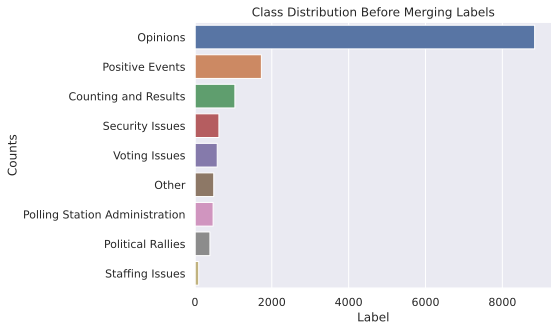

In [ ]:
# Visualise the distributions of the classes
# Get label distribution to visualise class imbalances
# Group by survey and calculate counts for each label

grouped_counts = labelled_data.groupby("label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

In [30]:
# Merge labels in the dataset
labelled_data["merged_label"] = labelled_data['label'].replace({'Polling Station Administration':"Voting Issues",'Staffing Issues':"Voting Issues", "Voting Issues":"Voting Issues", "Opinions":"Other"})

<ipython-input-30-4e28c2092582>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["merged_label"] = labelled_data['label'].replace({'Polling Station Administration':"Voting Issues",'Staffing Issues':"Voting Issues", "Voting Issues":"Voting Issues", "Opinions":"Other"})


In [31]:
# Create informative vs non-informative features
labelled_data["informative_label"] = labelled_data['label'].replace({'Polling Station Administration':'Informative', 'Staffing Issues':'Informative',
                                                                      'Voting Issues':"Informative",'Political Rallies':"Informative",
                                                                     "Positive Events":"Informative", "Other":"Non-Informative", 'Opinions':'Non-Informative',
                                                                     'Media Reports':'Informative', "Counting and Results":"Informative", "Security Issues":"Informative"})

<ipython-input-31-c3d1d8d0b347>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["informative_label"] = labelled_data['label'].replace({'Polling Station Administration':'Informative', 'Staffing Issues':'Informative',


In [32]:
labelled_data.shape

(14264, 13)

In [33]:
labelled_data['merged_label'].unique()

array(['Other', 'Political Rallies', 'Positive Events', 'Security Issues',
       'Voting Issues', 'Counting and Results'], dtype=object)

In [34]:
labelled_data['informative_label'].unique()

array(['Non-Informative', 'Informative'], dtype=object)

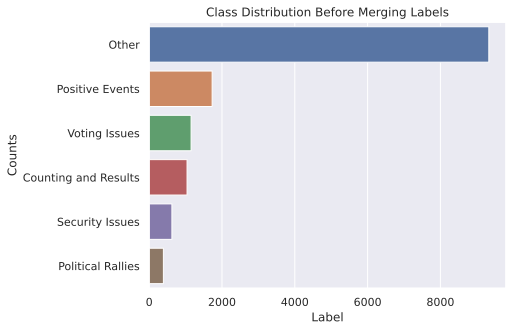

In [35]:
# Get label distribution to visualise class imbalances
# Group by survey and calculate counts for each label

grouped_counts = labelled_data.groupby("merged_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='merged_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

In [36]:
# Before assigning model data, check the number of tokens in each report as done in the baseline approach
labelled_data['word_count'] = labelled_data['clean_text'].apply(lambda x: len(tokenizer.tokenize(x)))

<ipython-input-36-12f227522aa8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data['word_count'] = labelled_data['clean_text'].apply(lambda x: len(tokenizer.tokenize(x)))


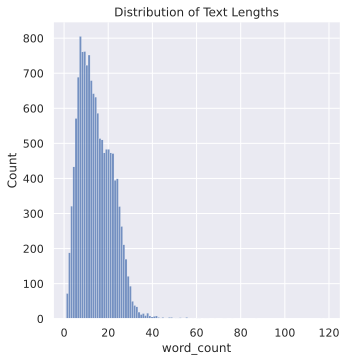

In [37]:
# Visualise word count distribution
sns.displot(labelled_data, x="word_count")
plt.title('Distribution of Text Lengths')
plt.show()

In [38]:
labelled_data['word_count'].describe()

count    14264.000000
mean        14.262058
std          7.841934
min          1.000000
25%          8.000000
50%         13.000000
75%         20.000000
max        119.000000
Name: word_count, dtype: float64

In [39]:
# Analyse the proportion of data that has less than 5 tokens after cleaning the data - similar to the BERT example for checking
lengths_en = labelled_data['word_count'].to_numpy()

min_len = 3

# Count the number of sequences that are longer than `max_len` tokens.
num_truncated = np.sum(np.less(lengths_en, min_len))

# Compare this to the total number of training sentences.
num_sentences = len(lengths_en)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are shorter than {:} tokens.'.format(num_truncated, num_sentences, prcnt, min_len))

260 of 14,264 sentences (1.8%) in the training set are shorter than 3 tokens.


In [40]:
# Drop all instances of text that are less than 3 tokens as they may not provide any useful information
# Drop rows where any column has a value less than the threshold
labelled_data = labelled_data.drop(labelled_data[labelled_data['word_count'] < min_len].index)

In [41]:
labelled_data.shape

(14004, 14)

In [42]:
model_data = labelled_data[['text', 'clean_text','normalized_text','merged_label', 'label', 'status', 'Election Date','date','informative_label']]

In [43]:
model_data.head()

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label
2,"Elections are coming. Youths should turn up,vote and Preach peace before, during and after the Elections. We can never be used and divided for selfish Political Interests.",elections coming youths turn vote preach peace elections never used divided selfish political interests,"Elections are coming . Youths should turn up , vote and Preach peace before , during and after the Elections . We can never be used and divided for selfish Political Interests .",Other,Opinions,published,August 2022,2022-07-05 05:08:29,Non-Informative
3,"It is important for youths to understand the election and voting processes, their role in the processes and how to ensure that peace is maintained even after elections.",important youths understand election voting processes role processes ensure peace maintained even elections,"It is important for youths to understand the election and voting processes , their role in the processes and how to ensure that peace is maintained even after elections .",Other,Opinions,published,August 2022,2022-07-05 05:16:28,Non-Informative
5,Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities!,voting one many ways young people make voices heard impact issues affect communities,Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities !,Other,Opinions,published,August 2022,2022-07-05 07:19:47,Non-Informative
6,Let's all stand out as youth to be agents of change by spreading the message of peace across all the borders within Kenya. Make an impact. There is elections and life after elections.,let stand youth agents change spreading message peace across borders within kenya make impact elections life elections,Let 's all stand out as youth to be agents of change by spreading the message of peace across all the borders within Kenya . Make an impact . There is elections and life after elections .,Other,Opinions,published,August 2022,2022-07-05 07:15:02,Non-Informative
8,Quite critical indeed @ItsKimaniThomas\nThe active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections.,quite critical indeed active meaningful participation young people kenya general elections ge requires precedent voter education also translates inclusive transparent process peace elections,Quite critical indeed @USER The active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections .,Other,Opinions,published,August 2022,2022-07-05 08:47:59,Non-Informative


In [44]:
# Encode the labels to numeric
labeller_informative = LabelEncoder()
model_data["informative_target"] = labeller_informative.fit_transform(model_data["informative_label"])

<ipython-input-44-6830f7cf63a0>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data["informative_target"] = labeller_informative.fit_transform(model_data["informative_label"])


In [45]:
informative_mapping = dict(zip(labeller_informative.classes_, range(len(labeller_informative.classes_))))
print(informative_mapping)

{'Informative': 0, 'Non-Informative': 1}


In [46]:
model_data[['normalized_text', 'informative_target']].head()

,normalized_text,informative_target
2,"Elections are coming . Youths should turn up , vote and Preach peace before , during and after the Elections . We can never be used and divided for selfish Political Interests .",1
3,"It is important for youths to understand the election and voting processes , their role in the processes and how to ensure that peace is maintained even after elections .",1
5,Voting is just one of the many ways young people can make their voices heard & have an impact on issues that affect them & their communities !,1
6,Let 's all stand out as youth to be agents of change by spreading the message of peace across all the borders within Kenya . Make an impact . There is elections and life after elections .,1
8,Quite critical indeed @USER The active and meaningful participation of young people in the Kenya General elections #GE2022 requires the precedent of voter education which also translates to an inclusive transparent process for peace in the elections .,1


In [47]:
# Extract temporal information from the dataset
# Include a column that has the absolute value of the number of days from the election
# Append the temporal info into the text

In [48]:
# Check the columns in the dataset
model_data.columns

Index(['text', 'clean_text', 'normalized_text', 'merged_label', 'label',
       'status', 'Election Date', 'date', 'informative_label',
       'informative_target'],
      dtype='object')

In [49]:
model_data['Election Date'].unique()

array(['August 2022', 'August 2017', 'October 2017'], dtype=object)

In [50]:
# Include temporal information i.e.; number of days after election and possibly time of the day
election_days_dict = {
    'August 2022': pd.to_datetime('2022-08-09'), # Retrieved from - https://en.wikipedia.org/wiki/2022_Kenyan_general_election
    'August 2017': pd.to_datetime('2017-08-09'), # Retrieved from - https://en.wikipedia.org/wiki/2017_Kenyan_general_election
    'October 2017': pd.to_datetime('2017-10-26') # Retrieved from - https://en.wikipedia.org/wiki/October_2017_Kenyan_presidential_election
}

In [51]:
def calculate_distance_from_election(election_label,report_date):
  """
  Calculates the distance in days between a given election label and a report date.

    Args:
        election_label (str): The label of the election.
        report_date (datetime.date): The date of the report.

    Returns:
        int: The absolute distance in days between the election and the report date.
    """
  distance = election_days_dict[election_label] - report_date
  return distance.days

In [52]:
model_data['date'] = pd.to_datetime(model_data['date'])

<ipython-input-52-2767b41c1ae6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['date'] = pd.to_datetime(model_data['date'])


In [53]:
model_data['election_distance'] = model_data.apply(lambda row: calculate_distance_from_election(row['Election Date'], row['date']), axis=1)

<ipython-input-53-72ee48015c9f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['election_distance'] = model_data.apply(lambda row: calculate_distance_from_election(row['Election Date'], row['date']), axis=1)


In [54]:
model_data['election_distance_abs'] = model_data['election_distance'].map(abs)

<ipython-input-54-8ec8c171ff69>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['election_distance_abs'] = model_data['election_distance'].map(abs)


In [55]:
model_data['election_distance'] = model_data['election_distance'].astype(int)
model_data['election_distance_abs'] = model_data['election_distance_abs'].astype(int)

<ipython-input-55-62bdee626ef1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['election_distance'] = model_data['election_distance'].astype(int)
<ipython-input-55-62bdee626ef1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['election_distance_abs'] = model_data['election_distance_abs'].astype(int)


<Figure size 1200x1000 with 0 Axes>

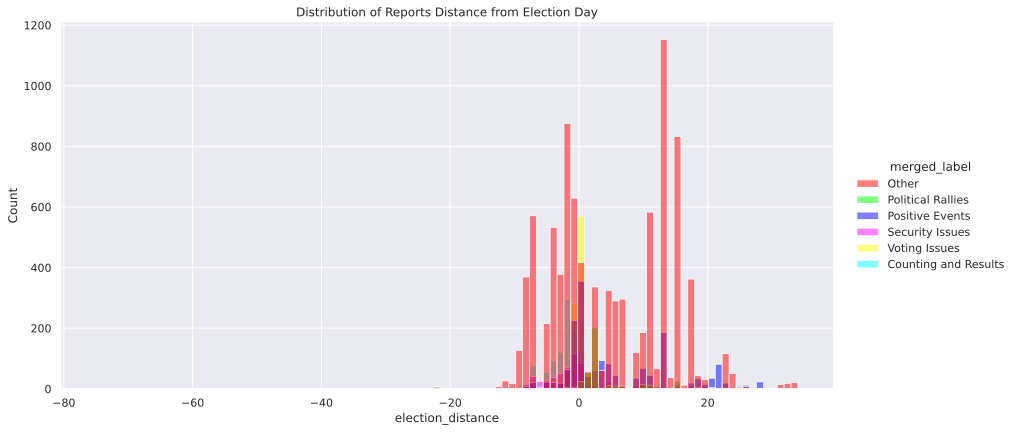

In [56]:
# Visualise word count distribution
# Define a list of colors with high contrast
colors = ["#FF0000", "#00FF00", "#0000FF", "#FF00FF", "#FFFF00", "#00FFFF"]

# Set the color palette in sns
sns.set_palette(colors)
plt.figure(figsize=(12, 10))
sns.displot(model_data, x="election_distance", hue='merged_label', height=6, aspect=2)
plt.title('Distribution of Reports Distance from Election Day')
plt.show()

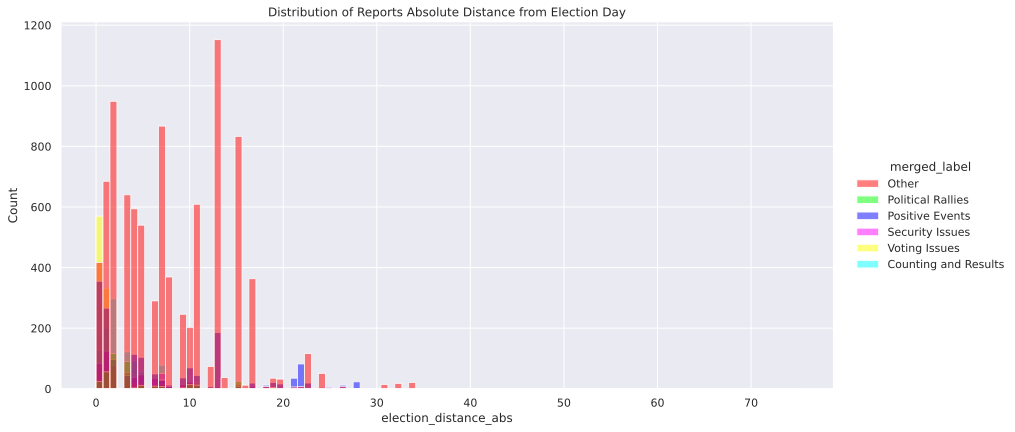

In [57]:
# Visualise word count distribution
# Define a list of colors with high contrast
colors = ["#FF0000", "#00FF00", "#0000FF", "#FF00FF", "#FFFF00", "#00FFFF"]
# Set the color palette in sns
sns.set_palette(colors)
sns.displot(model_data, x="election_distance_abs", hue='merged_label', height=6, aspect=2)
plt.title('Distribution of Reports Absolute Distance from Election Day')
plt.show()

In [58]:
model_data['date'].sample(10)

8397    2022-07-28 07:12:39
11359   2022-08-04 12:54:52
7143    2022-07-26 10:45:25
6456    2022-07-24 19:59:10
2172    2022-08-15 18:57:15
3206    2022-08-17 06:11:47
1427    2022-08-13 06:42:52
13363   2022-08-09 22:47:50
13584   2022-08-10 05:43:52
10313   2022-08-10 10:30:54
Name: date, dtype: datetime64[ns]

<ipython-input-59-a4d596ba88a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['hour'] = model_data['date'].dt.hour


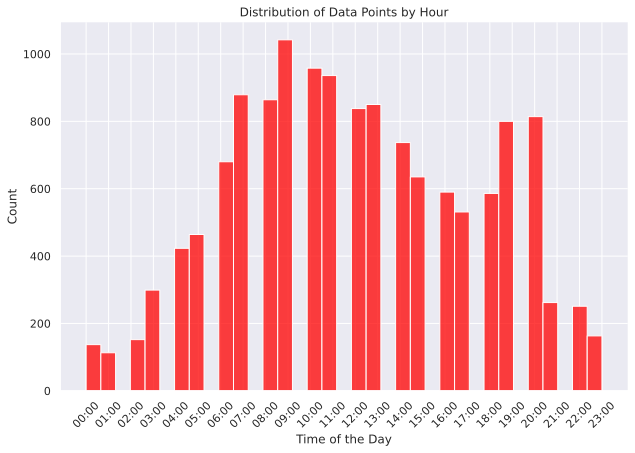

In [59]:
# Extract the hour component from the 'date' column
model_data['hour'] = model_data['date'].dt.hour
# Plot the distribution of data points based on the time of the day
sns.displot(data=model_data, x='hour', height=6, aspect=1.5)
# Set the x-axis tick labels to display actual times
plt.xticks(range(24), [f'{hour:02d}:00' for hour in range(24)])

# Set plot labels and title
plt.xlabel('Time of the Day')
plt.ylabel('Count')
plt.title('Distribution of Data Points by Hour')

# Rotate x-axis tick labels for better visibility (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

<ipython-input-60-5740f720314f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['hour'] = model_data['date'].dt.hour


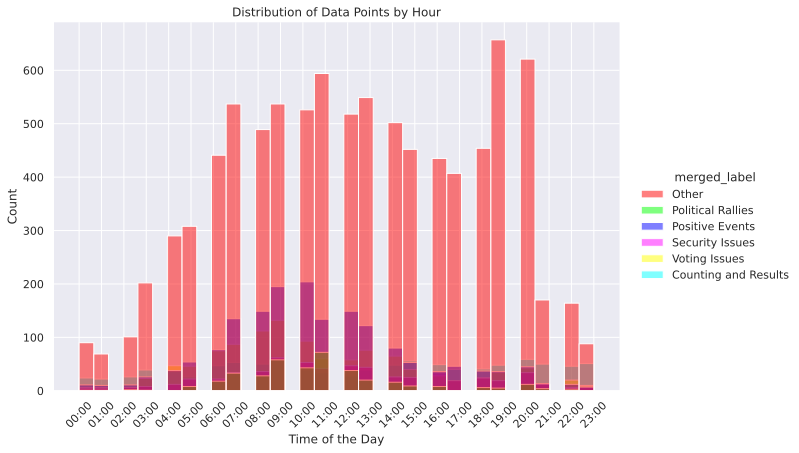

In [60]:
# Extract the hour component from the 'date' column
model_data['hour'] = model_data['date'].dt.hour
sns.set_palette(colors)
# Plot the distribution of data points based on the time of the day
sns.displot(data=model_data, x='hour', height=6, aspect=1.5, hue='merged_label')
# Set the x-axis tick labels to display actual times
plt.xticks(range(24), [f'{hour:02d}:00' for hour in range(24)])

# Set plot labels and title
plt.xlabel('Time of the Day')
plt.ylabel('Count')
plt.title('Distribution of Data Points by Hour')

# Rotate x-axis tick labels for better visibility (optional)
plt.xticks(rotation=45)

# Display the plot
plt.show()

In [61]:
# Split the data into train, validation and test datasets
# Get the text context for embedding - set size to 3 (medium) posts and add it to the combined text
# Combine all the text - be done with validation by 7pm (there's only so much you can do)

In [62]:
informative_df = model_data[model_data['merged_label'] != 'Other']

In [63]:
informative_df.shape

(4803, 13)

In [64]:
labeller = LabelEncoder()
informative_df["target"] = labeller.fit_transform(informative_df["merged_label"])
mapping = dict(zip(labeller.classes_, range(len(labeller.classes_))))
print(mapping)

{'Counting and Results': 0, 'Political Rallies': 1, 'Positive Events': 2, 'Security Issues': 3, 'Voting Issues': 4}


<ipython-input-64-9b6e01ad96fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  informative_df["target"] = labeller.fit_transform(informative_df["merged_label"])


In [78]:
# Split the data into train, validation and test datasets
train_data, test_data = train_test_split(model_data, test_size=0.15, random_state=0)

In [79]:
print(train_data.shape, test_data.shape)

(11903, 13) (2101, 13)


In [80]:
# Get context

In [81]:
def get_context(df, support_df, context_size=2):
  '''
  This function takes two dataframes, the first, df - is the dataframe to calculate
  context embeddings for while the support df is the reference to use to check the
  context, in the case of train data, both the df and support df will be the same,
  this is to ensure that no test data leaks into the training context embeddings. For
  test embeddings, the support df will be the whole dataset
  '''
  contexts = []
  sorted_dates = df.sort_values('date')['date']
  dates_list = sorted_dates.to_list()
  # Iterate over rows using iterrows()
  for index, row in df.iterrows():
    current_date = row['date']
    current_date_index = dates_list.index(current_date)
    previous_posts = dates_list[max(0, current_date_index - context_size) : current_date_index]
    context = ""
    for idx, dt in enumerate(previous_posts):
      record = support_df[support_df['date'] == dt].iloc[0]
      # Only consider context fromt the same election
      if record['Election Date'] == row['Election Date']:
        context += "{:}. ".format(record.normalized_text)
    contexts.append(context)
  return contexts

In [82]:
train_contexts = get_context(train_data, train_data)

In [83]:
train_contexts[:3]

['Vice President of Law Society of Kenya , Faith Odhiambo , called on the members to ensure fairness in executing their duties . She reminded the Commission that the public was watching , and it must therefore ensure that the election is free , fair and credible . #GE2022. Commissioner Francis Wanderi urged LSK to take part in the process of legal reform so as improve the electoral laws .. ',
 'They are looking for forms they did not make ? IEBC is joking . I withdrew mine long ago .. IEBC MUST Comply with all ELECTIONS Regulations . I welcome their truce with the Police today . I know they committed to rectify the mishaps silently but we will amplify LOUDLY should they go astray AGAIN ! Tuko Macho !. ',
 'Ca n\'t buy DCI story on Venezuelans smartmatic employee \'s contracted by IEBC . Initially , they released a statement that they \'d not arrested anyone as claimed by Chebukati . Today , they release another contradictory statement . DCI & Kenya Police are well known for fabricating

In [84]:
test_contexts = get_context(test_data, model_data)

In [85]:
print(len(train_contexts), len(test_contexts))

11903 2101


In [86]:
train_data["context"] = train_contexts

In [87]:
test_data['context'] = test_contexts

In [88]:
train_data.head()

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,informative_target,election_distance,election_distance_abs,hour,context
4054,Commissioner Irene called upon the Advocates to be ready to represent the Commission in the event of election petitions. She noted that the sensitization workshop will ensure that the Commission’s Advocates are well briefed on their expectations by the Commission. \n#GE2022,commissioner irene called upon advocates ready represent commission event election petitions noted sensitization workshop ensure commissions advocates well briefed expectations commission ge,Commissioner Irene called upon the Advocates to be ready to represent the Commission in the event of election petitions . She noted that the sensitization workshop will ensure that the Commission 's Advocates are well briefed on their expectations by the Commission . #GE2022,Other,Opinions,published,August 2022,2022-07-15 05:58:41,Non-Informative,1,24,24,5,"Vice President of Law Society of Kenya , Faith Odhiambo , called on the members to ensure fairness in executing their duties . She reminded the Commission that the public was watching , and it must therefore ensure that the election is free , fair and credible . #GE2022. Commissioner Francis Wanderi urged LSK to take part in the process of legal reform so as improve the electoral laws .."
5001,"The meeting agreed that Presiding Officers will use one results form 34A booklet, while the second one will remain unsused and sealed in the ballot box after the polling, counting and announcement of results.",meeting agreed presiding officers use one results form booklet second one remain unsused sealed ballot box polling counting announcement results,"The meeting agreed that Presiding Officers will use one results form 34A booklet , while the second one will remain unsused and sealed in the ballot box after the polling , counting and announcement of results .",Positive Events,Positive Events,published,August 2022,2022-07-29 14:45:49,Informative,0,10,10,14,They are looking for forms they did not make ? IEBC is joking . I withdrew mine long ago .. IEBC MUST Comply with all ELECTIONS Regulations . I welcome their truce with the Police today . I know they committed to rectify the mishaps silently but we will amplify LOUDLY should they go astray AGAIN ! Tuko Macho !.
5590,"I knew that by the time Chebukati started clucking like a hen on heat, it was immediately clear something was wrong. Has he responded to a report from DCI?",knew time chebukati started clucking like hen heat immediately clear something wrong responded report dci,"I knew that by the time Chebukati started clucking like a hen on heat , it was immediately clear something was wrong . Has he responded to a report from DCI ?",Other,Opinions,published,August 2022,2022-07-24 08:16:50,Non-Informative,1,15,15,8,"Ca n't buy DCI story on Venezuelans smartmatic employee 's contracted by IEBC . Initially , they released a statement that they 'd not arrested anyone as claimed by Chebukati . Today , they release another contradictory statement . DCI & Kenya Police are well known for fabricating stories .. Well , yesterday DCI denied to have arrested and detained such persons ! Haya , National Police Service statement said , "" Subsequent investigation have revealed that stickers are bona fide property of IEBC."
1540,H.E Raila Amolo Odinga- President elect. Congragulations sir. Go forth and make Kenya a better Republic.,h e raila amolo odinga president elect congragulations sir go forth make kenya better republic,H . E Raila Amolo Odinga - President elect . Congragulations sir . Go forth and make Kenya a better Republic .,Other,Opinions,published,August 2022,2022-08-15 09:19:37,Non-Informative,1,-7,7,9,Kenya ni mimi na Kenya ni wewe #kenyaelections2022 #KenyanElection2022. Live Results from the BBC.
10789,A peaceful nation is a good home to live.May God peace be upon #Kenyan hearts.\n8th August Vote for Peac

In [136]:
sep = ' [SEP] '
def combine_features(df):
  sentences = []
  labels = []
  print('Combining features into strings...')
  # For each of the samples...
  for index, row in df.iterrows():
      # Piece it together...
      context = row["context"]
      text = row["normalized_text"]
      combined_text = context + text
      sentences.append(combined_text)
      labels.append(row["informative_label"])
  print('  DONE.')
  print('Dataset contains {:,} samples.'.format(len(sentences)))
  return sentences, labels

In [137]:
train_sentences, train_targets = combine_features(train_data)
test_sentences, test_targets = combine_features(test_data)

Combining features into strings...
  DONE.
Dataset contains 11,903 samples.
Combining features into strings...
  DONE.
Dataset contains 2,101 samples.


In [138]:
train_sentences[0]

"Vice President of Law Society of Kenya , Faith Odhiambo , called on the members to ensure fairness in executing their duties . She reminded the Commission that the public was watching , and it must therefore ensure that the election is free , fair and credible . #GE2022. Commissioner Francis Wanderi urged LSK to take part in the process of legal reform so as improve the electoral laws .. Commissioner Irene called upon the Advocates to be ready to represent the Commission in the event of election petitions . She noted that the sensitization workshop will ensure that the Commission 's Advocates are well briefed on their expectations by the Commission . #GE2022"

In [139]:
# Split train data to validation
train_sentences, validation_sentences, train_targets, validation_targets = train_test_split(train_sentences, train_targets,
                                                                                            test_size=0.15, random_state=0)

In [140]:
print(len(train_sentences), len(validation_sentences), len(test_sentences))

10117 1786 2101


In [141]:
train_sentences[0]

'IEBC in-conjunction with Disability Mainstreaming Foundation of Kenya ( DMF-K ) today launched Braille Version of Voter Education Materials to promote inclusion in dissemination of electoral information for Persons with Disabilities ( PWDs ) in Kenya .. IEBC in partnership with DMF-Kenya is carrying out voter education to ensure that PWDs are included and fully participate in the #GE2022 . The organization has transcribed voter education materials into BRAILLE and other forms which are friendly to PWDs .. Youths are part of the special groups in the electoral process . Their participation in the #GE2022 will build confidence in themselves , encourage participation in elections , by-elections and referenda & mitigate stereotypes against them'

In [142]:
# Check whether GPU is detected
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [143]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla V100-SXM2-16GB


In [144]:
# Install transformers lib
!pip install transformers

In [145]:
!pip install sentencepiece

In [146]:
import torch
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')

# from transformers import XLMRobertaTokenizer

# # # Download the tokenizer for the XLM-Robert `base` model.
# tokenizer = XLMRobertaTokenizer.from_pretrained("bert-base-multilingual-uncased")

In [147]:
# Print the original sentence.
print(' Original: ', train_sentences[10])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(train_sentences[10]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(train_sentences[10])))

 Original:  NationBreakingNews ‏ Verified account @USER ANOTHER KITUI county official attached to finance dept arrested on voter bribery allegations . Cash & staff ID confiscated . #ElectionsKE. How can we vote while being tear gased , iebc officials are not operating. Voter assisters took oath of secrecy effectively #Kuria West #KIBURANGA PRI .
Tokenized:  ['▁Nation', 'B', 'rea', 'king', 'News', '▁Ver', 'ified', '▁account', '▁@', 'U', 'SER', '▁AN', 'OTHER', '▁', 'KIT', 'UI', '▁count', 'y', '▁official', '▁attached', '▁to', '▁finance', '▁de', 'pt', '▁arrest', 'ed', '▁on', '▁voter', '▁bri', 'ber', 'y', '▁alle', 'gation', 's', '▁', '.', '▁Cash', '▁&', '▁staff', '▁ID', '▁confisca', 'ted', '▁', '.', '▁#', 'El', 'ection', 's', 'KE', '.', '▁How', '▁can', '▁we', '▁vote', '▁while', '▁being', '▁te', 'ar', '▁gas', 'ed', '▁', ',', '▁i', 'e', 'bc', '▁official', 's', '▁are', '▁not', '▁operating', '.', '▁Vo', 'ter', '▁assist', 'ers', '▁took', '▁o', 'ath', '▁of', '▁se', 'cre', 'cy', '▁effectively', '▁

In [148]:
# Measure the maximum length of the sentences
max_len = 0
lengths_en = []
# For every sentence...
for sent in train_sentences:
    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    # Record the length.
    lengths_en.append(len(input_ids))
    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))
print('Max sentence length: ', max_len)

Max sentence length:  474


In [149]:
print('Min length: {:,} tokens'.format(min(lengths_en)))
print('Max length: {:,} tokens'.format(max(lengths_en)))
print('Median length: {:,} tokens'.format(int(np.median(lengths_en))))

Min length: 8 tokens
Max length: 474 tokens
Median length: 127 tokens


<ipython-input-151-dbf6ccc1c3ba>:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(lengths_en, kde=False, rug=False, hist_kws={'alpha': 1, 'edgecolor': 'black'})


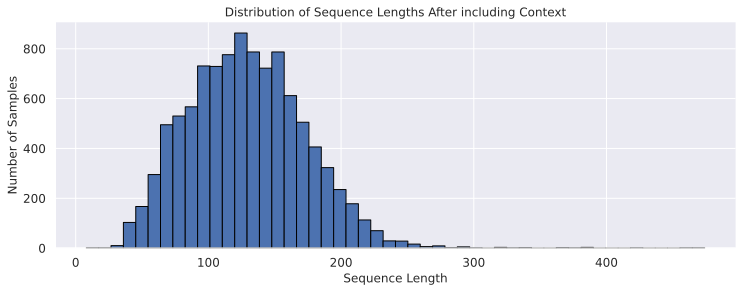

In [151]:
import seaborn as sns
import matplotlib.pyplot as plt

# Visualize the distribution of sequence lengths

custom_palette = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Set style for scientific publications
sns.set_theme(style='white', font_scale=1.0)  # Reduced font scale
sns.set_palette("Set2")

# Increase the plot size and font size
sns.set(font_scale=1)
# Create the plot with a white background
plt.figure(figsize=(10.5, 4.27), facecolor='white')

# Plot the distribution of sequence lengths without grids
sns.distplot(lengths_en, kde=False, rug=False, hist_kws={'alpha': 1, 'edgecolor': 'black'})

# Add title and labels
plt.title('Distribution of Sequence Lengths After including Context')
plt.xlabel('Sequence Length')
plt.ylabel('Number of Samples')

# Emphasize the x-axis and y-axis
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Keep only left and bottom border lines
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)

# Display the plot
plt.tight_layout()  # Ensures labels don't overlap
plt.savefig("sequence_lengths_distribution_with_context.svg", dpi=300)  # Save the figure
plt.show()

In [152]:
max_len = 300

# Count the number of sequences that are longer than `max_len` tokens.
num_truncated = np.sum(np.greater(lengths_en, max_len))

# Compare this to the total number of training sentences.
num_sentences = len(lengths_en)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are longer than {:} tokens.'.format(num_truncated, num_sentences, prcnt, max_len))

15 of 10,117 sentences (0.1%) in the training set are longer than 300 tokens.


A negligible proportion of the dataset has tokens longer than 128

In [ ]:
def tokenize(sentences, labels):
  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 256,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])

  return input_ids, attention_masks, labels

In [ ]:
# # Tokenize all of the sentences and map the tokens to thier word IDs.
# input_ids = []
# attention_masks = []

# # For every sentence...
# for sent in sentences:
#     # `encode_plus` will:
#     #   (1) Tokenize the sentence.
#     #   (2) Prepend the `[CLS]` token to the start.
#     #   (3) Append the `[SEP]` token to the end.
#     #   (4) Map tokens to their IDs.
#     #   (5) Pad or truncate the sentence to `max_length`
#     #   (6) Create attention masks for [PAD] tokens.
#     encoded_dict = tokenizer.encode_plus(
#                         sent,                      # Sentence to encode.
#                         add_special_tokens = True, # Add '[CLS]' and '[SEP]'
#                         max_length = 256,           # Pad & truncate all sentences.
#                         pad_to_max_length = True,
#                         return_attention_mask = True,   # Construct attn. masks.
#                         return_tensors = 'pt',     # Return pytorch tensors.
#                    )

#     # Add the encoded sentence to the list.
#     input_ids.append(encoded_dict['input_ids'])

#     # And its attention mask (simply differentiates padding from non-padding).
#     attention_masks.append(encoded_dict['attention_mask'])

# # Convert the lists into tensors.
# input_ids = torch.cat(input_ids, dim=0)
# attention_masks = torch.cat(attention_masks, dim=0)
# labels = torch.tensor(labels)

# # Print sentence 0, now as a list of IDs.
# print('Original: ', sentences[0])
# print('Token IDs:', input_ids[0])

In [ ]:
train_input_ids, train_attention_masks, train_labels = tokenize(train_sentences, train_targets)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  IEBC Confirms Susan Kihika 's Nakuru County Gubernatorial Win #Deleted #Junet #Itumbi #RutoThe5th #RailaThe5th #Jayden #KICC #Bomas
Token IDs: tensor([     0,     87, 171408,   1657,  38949,      7,  67243,   1519,    979,
           161,    242,      7,    353, 120209,  47064,   6955,   1297,     76,
         77275,  17686,    468,    397,   1018,   3674,    468,  97866,    126,
           468,  23389, 103731,    468,  26951,    188,   3957,    758,    927,
           468,  12248,   2439,   3957,    758,    927,    468,   6979,     53,
           555,    468,  17713,  13709,    468,  12647,   1510,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1

In [ ]:
dev_input_ids, dev_attention_masks, dev_labels = tokenize(validation_sentences, validation_targets)

Original:  Kenya kwanza took their campaigns yesterday . Led by their presidential candidate Dr William Ruto , they urged Makueni residents to turn up in large numbers and vote kenya kwanza
Token IDs: tensor([     0,  23357,  25988,  34739,   2363,  80399,      7, 131101,      6,
             5,  45470,    390,   2363,  79169,    289,  25469,     13,   1773,
         25031,   4518,    188,      6,      4,   1836, 104687,     71, 149722,
          4300, 160641,     47,  15504,   1257,     23,  21334, 101935,    136,
         43374,    311,    273,  25988,      2,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,

In [ ]:
test_input_ids, test_attention_masks, test_labels = tokenize(test_sentences, test_targets)

Original:  As of 2:30 pm ; #RailaOdinga - 56.69 % ; #WilliamRuto - 48.76 % 0.35 percent George Wajackoyah 0.20 % David Waihiga
Token IDs: tensor([     0,   1301,    111,  15573,   1197,   3592,   2819,    468,  12248,
          2439,    670, 132982,     20,   9103,      5,  14212,   1745,   2819,
           468, 222523,  26951,    188,     20,   4572,      5,  11835,   1745,
        127089,    758,  33297,  14787,   3316, 135758,     31,  30525,    757,
             5,   1549,   1745,   6765,   3316,   1043,   1758,      2,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1,      1,      1,
             1,      1,      1,      1,      1,      1,      1

In [ ]:
# from torch.utils.data import TensorDataset, random_split

# random.seed(seed_val)

# # Combine the training inputs into a TensorDataset.
# dataset = TensorDataset(input_ids, attention_masks, labels)

# # Create a 70-15-15 train-validation-test split.

# # Calculate the number of samples to include in each set.
# train_size = int(0.7 * len(dataset))
# val_size = int(0.15 * len(dataset))
# test_size = len(dataset) - train_size - val_size

# # Divide the dataset by randomly selecting samples.
# train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# print('{:>5,} training samples'.format(train_size))
# print('{:>5,} validation samples'.format(val_size))
# print('{:>5,} test samples'.format(test_size))


In [ ]:
from torch.utils.data.dataset import TensorDataset
train_dataset = TensorDataset(train_input_ids, train_attention_masks, train_labels)
val_dataset = TensorDataset(dev_input_ids, dev_attention_masks, dev_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_masks, test_labels)

In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# # For validation the order doesn't matter, so we'll just read them sequentially.
test_dataloader = DataLoader(
            test_dataset, # The validation samples.
            sampler = SequentialSampler(test_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
type(train_dataset)

torch.utils.data.dataset.TensorDataset

In [ ]:
labels = train_dataset[:][2].numpy()

In [ ]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3, 4]), array([ 714,  275, 1204,  448,  828]))

In [ ]:
# Estimate the class weights to be used in the model training
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(labels), y=labels)
class_weights = torch.tensor(class_weights,dtype=torch.float)

In [ ]:
weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

print(weights)

{0: tensor(0.9717), 1: tensor(2.5229), 2: tensor(0.5762), 3: tensor(1.5487), 4: tensor(0.8379)}


In [ ]:
from transformers import XLMRobertaForSequenceClassification
from transformers import AutoModelForSequenceClassification, AutoModel
import torch

#from transformers import XLMTokenizer, XLMForSequenceClassification

# xlmr_model = AutoModel.from_pretrained("roberta-base", num_labels=6)
xlmr_model = XLMRobertaForSequenceClassification.from_pretrained("xlm-roberta-base", num_labels=5)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_pr

In [ ]:
print('Loading model to GPU...')

# Connect to the GPU.
device = torch.device('cuda')

# Report what GPU we were granted.
print('  GPU:', torch.cuda.get_device_name(0))

# Copy the initial model weights to the GPU.
desc = xlmr_model.to(device)

print('DONE.')

Loading model to GPU...
  GPU: Tesla V100-SXM2-16GB
DONE.


In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = torch.optim.AdamW(xlmr_model.parameters(),
                  lr = 2e-5, # args.learning_rate
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )

In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    This function will try to pick an intelligent progress update interval
    based on the magnitude of the total iterations.

    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the
                              course of the for-loop.
    '''
    # Divide the total iterations by the desired number of updates. Most likely
    # this will be some ugly number.
    exact_interval = total_iters / num_desired_updates

    # The `round` function has the ability to round down a number to, e.g., the
    # nearest thousandth: round(exact_interval, -3)
    #
    # To determine the magnitude to round to, find the magnitude of the total,
    # and then go one magnitude below that.

    # Get the order of magnitude of the total.
    order_of_mag = len(str(total_iters)) - 1

    # Our update interval should be rounded to an order of magnitude smaller.
    round_mag = order_of_mag - 1

    # Round down and cast to an int.
    update_interval = int(round(exact_interval, -round_mag))

    # Don't allow the interval to be zero!
    if update_interval == 0:
        update_interval = 1

    return update_interval

In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    xlmr_model.train()

    # Pick an interval on which to print progress updates.
    update_interval = good_update_interval(
                total_iters = len(train_dataloader),
                num_desired_updates = 10
            )

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update.
        if (step % update_interval) == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        xlmr_model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = xlmr_model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       return_dict=True)

        logits = result.logits
        # loss = result.loss

        criterion = torch.nn.CrossEntropyLoss(weight=class_weights.to(device), reduction='mean')
        loss = criterion(logits, b_labels)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(xlmr_model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))


    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    xlmr_model.eval()

    # Tracking variables
    total_eval_loss = 0


    predictions, true_labels = [], []

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = xlmr_model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        logits = result.logits

        # Calculate the loss without applying class weights
        criterion = torch.nn.CrossEntropyLoss(reduction='mean')
        loss = criterion(logits, b_labels)

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Calculate the accuracy for this batch of test sentences.

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Store predictions and true labels
        predictions.append(logits)
        true_labels.append(label_ids)

    # Measure validation accuracy...

    # Combine the results across all batches.
    flat_predictions = np.concatenate(predictions, axis=0)
    flat_true_labels = np.concatenate(true_labels, axis=0)

    # For each sample, pick the label (0, 1, or 2) with the highest score.
    predicted_labels = np.argmax(flat_predictions, axis=1).flatten()

    # Calculate the validation accuracy.
    val_accuracy = (predicted_labels == flat_true_labels).mean()

    # Report the final accuracy for this validation run.
    print("  Accuracy: {0:.2f}".format(val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    10  of    109.    Elapsed: 0:00:04.
  Batch    20  of    109.    Elapsed: 0:00:08.
  Batch    30  of    109.    Elapsed: 0:00:13.
  Batch    40  of    109.    Elapsed: 0:00:17.
  Batch    50  of    109.    Elapsed: 0:00:21.
  Batch    60  of    109.    Elapsed: 0:00:25.
  Batch    70  of    109.    Elapsed: 0:00:30.
  Batch    80  of    109.    Elapsed: 0:00:34.
  Batch    90  of    109.    Elapsed: 0:00:38.
  Batch   100  of    109.    Elapsed: 0:00:42.

  Average training loss: 1.40
  Training epoch took: 0:00:46

Running Validation...
  Accuracy: 0.63
  Validation Loss: 0.98
  Validation took: 0:00:02

======== Epoch 2 / 4 ========
Training...
  Batch    10  of    109.    Elapsed: 0:00:04.
  Batch    20  of    109.    Elapsed: 0:00:09.
  Batch    30  of    109.    Elapsed: 0:00:13.
  Batch    40  of    109.    Elapsed: 0:00:17.
  Batch    50  of    109.    Elapsed: 0:00:21.
  Batch    60  of    109.    Elapsed: 0:00:26.
  Batch  

In [ ]:
import pandas as pd

# Display floats with two decimal places.
# pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.404308,0.975495,0.632953,0:00:46,0:00:02
2,0.923603,0.808898,0.727569,0:00:46,0:00:02
3,0.697452,0.802228,0.706362,0:00:46,0:00:02
4,0.601140,0.795458,0.725938,0:00:46,0:00:02


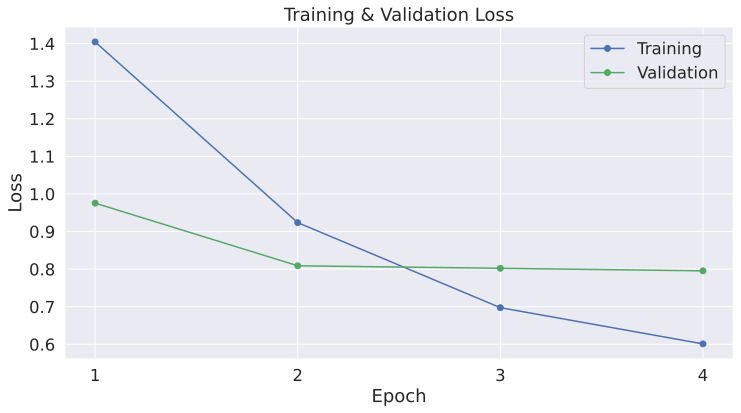

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Prediction on test set

# Put model in evaluation mode
xlmr_model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = xlmr_model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('DONE.')

DONE.


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


<ipython-input-297-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


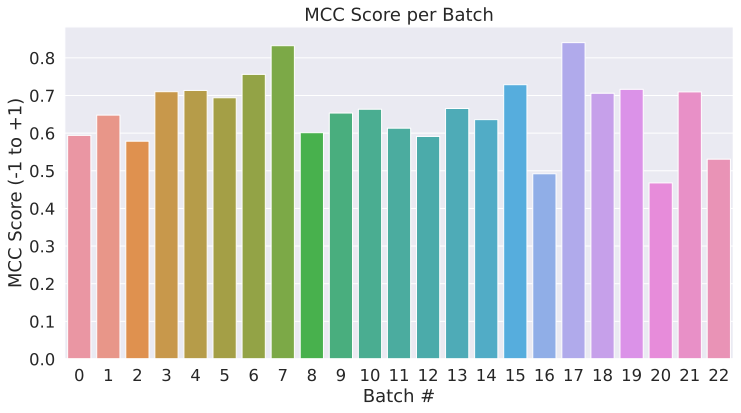

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.659


In [ ]:
len(flat_predictions)

721

In [ ]:
# Tally the number of correct predictions to get our accuracy.
accuracy = (flat_predictions == flat_true_labels).mean()

print('XLM-R Prediction accuracy: {:.3f}'.format(accuracy))

XLM-R Prediction accuracy: 0.735


In [ ]:
print(classification_report(flat_true_labels,
                                flat_predictions,
                                target_names=mapping.keys()))

                      precision    recall  f1-score   support

Counting and Results       0.78      0.81      0.80       160
   Political Rallies       0.73      0.90      0.80        59
     Positive Events       0.84      0.67      0.74       247
     Security Issues       0.58      0.71      0.64        83
       Voting Issues       0.67      0.72      0.69       172

            accuracy                           0.74       721
           macro avg       0.72      0.76      0.73       721
        weighted avg       0.75      0.74      0.74       721



In [ ]:
 #Util function to plot confusion matrix
def plot_cm(labels, predictions, class_labels):
    # predictions has values in [0,1]
    cm = confusion_matrix(labels, predictions)
    # Change figure size and increase dpi for better resolution
    plt.figure(figsize=(8,6), dpi=100)
    # Scale up the size of all text
    sns.set(font_scale = 1.1)
    # Plot Confusion Matrix using Seaborn heatmap()
    # Parameters:
    # first param - confusion matrix in array format
    # annot = True: show the numbers in each heatmap cell
    # fmt = 'd': show numbers as integers.
    ax = sns.heatmap(cm, annot=True, fmt='d', )
    # set x-axis label and ticks.

  # Set x-axis label and ticks
    ax.set_xlabel("Predicted Label", fontsize=14, labelpad=20)
    ax.set_xticklabels(class_labels, rotation=45, ha='right')

    # Set y-axis label and ticks
    ax.set_ylabel("Gold Label", fontsize=14, labelpad=20)
    ax.set_yticklabels(class_labels, rotation=45, ha='right')

    # set plot title
    ax.set_title("Confusion Matrix", fontsize=14, pad=20)

    plt.show()

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [ ]:
from sklearn.preprocessing import label_binarize
import numpy as np

# get the number of classes
n_classes = len(np.unique(flat_true_labels))

# classes = [0,1,2,3]
classes   = np.sort(np.unique(flat_true_labels))

# relabel the test set
y_true = label_binarize(flat_true_labels,
                        classes=classes)

In [ ]:
def plot_roc(y_true, y_pred, mapping):
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true.ravel(), y_pred.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Compute macro-average ROC curve and ROC area
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(n_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= n_classes
    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # Create a new figure with a specific size
    plt.figure(figsize=(8, 6))  # Specify the width and height in inches
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                label='{0} (area = {1:0.2f})'
                    ''.format(mapping[i], roc_auc[i]))

    # Add diagonal line for reference
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')

    # Set plot properties
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()

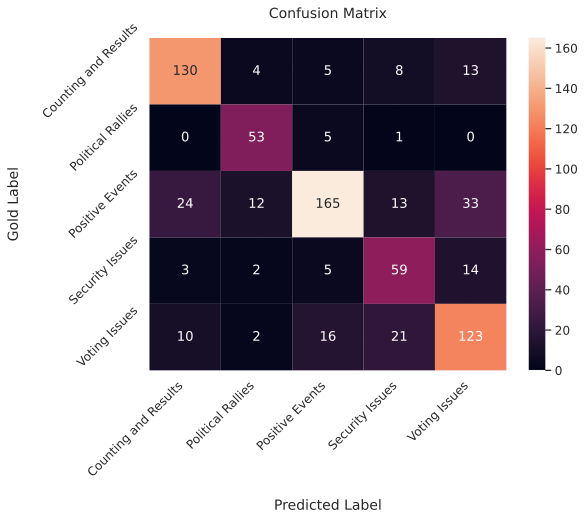

In [ ]:
plot_cm(flat_true_labels, flat_predictions, list(mapping.keys()))

In [ ]:
idx_to_class = {value: key for key, value in mapping.items()}
idx_to_class

{0: 'Counting and Results',
 1: 'Other',
 2: 'Political Rallies',
 3: 'Positive Events',
 4: 'Security Issues',
 5: 'Voting Issues'}

In [ ]:
# Combine the results across all batches.
y_pred_proba = np.concatenate(predictions, axis=0)

In [ ]:
y_true

array([[0],
       [1],
       [1],
       ...,
       [1],
       [0],
       [1]])

In [ ]:
plot_roc(y_true,y_pred_proba,idx_to_class)

IndexError: ignored

In [ ]:
test_sentences = test_dataset[:][0].numpy()

In [ ]:
decoded_sentences = []
for ts in test_sentences:
  decoded_sent = tokenizer.decode(ts)
  # print(decoded_sent)
    # Remove special tokens
  decoded_sent = decoded_sent.replace('[CLS]', '').replace('[PAD]', '').replace('[SEP]', '').replace('</s>', '')
  decoded_sent = decoded_sent.lstrip()
  decoded_sentences.append(decoded_sent)


In [ ]:
inspect_df = pd.DataFrame({'text': decoded_sentences, 'Label': flat_true_labels, 'Predicted Label': flat_predictions})


In [ ]:
idx_to_class = {value: key for key, value in mapping.items()}
idx_to_class

In [ ]:
inspect_df.Label = inspect_df.Label.map(idx_to_class)

In [ ]:
inspect_df['Predicted Label'] = inspect_df['Predicted Label'].map(idx_to_class)

In [ ]:
inspect_df.sample(20)

In [ ]:
clean_text = 'william ruto raila odinga luchiri wajackoyah waihiga mwaure standby notifications'

In [ ]:
original_text = labelled_data[labelled_data.clean_text == clean_text]['text'].iloc[0]

In [ ]:
original_text

In [ ]:
labelled_data.head()

In [ ]:
# Retrieve original texts
def get_original_text(clean_text):
  original_text = labelled_data[labelled_data.clean_text == clean_text]['text']
  if not original_text.empty:
    return original_text.iloc[0]
  else:
    return None

In [ ]:
inspect_df['original_text'] = inspect_df.apply(lambda row: get_original_text(row['text']), axis=1)

In [ ]:
inspect_df['original_text'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 743 entries, 0 to 742
Series name: original_text
Non-Null Count  Dtype 
--------------  ----- 
743 non-null    object
dtypes: object(1)
memory usage: 5.9+ KB


In [ ]:
inspect_df[(inspect_df['Label'] != inspect_df['Predicted Label']) & (inspect_df['Label'] == 'Positive Events')][['text','original_text','Label','Predicted Label']].sample(10)

,text,original_text,Label,Predicted Label
407,kenyas first lady waits line like voters cast ballot,Kenya’s First Lady waits in line like other voters to cast her ballot,Positive Events,Voting Issues
277,machine okkuria eastremanyanki,Now the machine is ok#KURIA EAST#REMANYANKI,Positive Events,Counting and Results
310,iebc officials immediately reported results prescribed time suna east,IEBC officials immediately reported results at prescribed time... 20:14#Suna-East,Positive Events,Counting and Results
444,presiding officer captured rejected ballot papers form marked rejectedkuria westkendege,Presiding officer captured all rejected ballot papers on form marked ‘Rejected’#KURIA WEST#KENDEGE,Positive Events,Voting Issues
240,real propaganda debunked kenyans expect rise azimio cultism condemn equal measure let iebc work,This is the real propaganda about to be debunked. Kenyans expect you to rise above Azimio cultism and condemn such in equal measure too. Let IEBC do it's work.,Positive Events,Political Rallies
459,hukukwetu hakunaumabya ni maich kutoka kigajo,Hukukwetu hakunaumabya ni maich kutoka kigañjo,Positive Events,Security Issues
538,far casted vote nyandema polling station rangwe sub county homabay county waiting results,"so far, i have casted my vote from nyandema polling station in rangwe sub county homabay county. We are only waiting for the results.",Positive Events,Voting Issues
42,polling number kabete technical polling centre code good working kits friendly iebc officials well done iebc,Polling number 6 at kabete technical polling centre code 23 had good working kits and friendly IEBC officials. Well done IEBC,Positive Events,Voting Issues
326,iebc discovers fourteen returning officers million unrecognized voters,IEBC discovers fourteen (14) returning officers and more than 2 million unrecognized voters,Positive Events,Counting and Results
467,weno tunalewa ju ya iebc kua transparent,Weno tunalewa ju ya iebc kua transparent,Positive Events,Security Issues


In [ ]:
inspect_df.to_csv('misclassified')

In [ ]:
inspect_df.head()

,text,Label,Predicted Label,original_text
0,k,Voting Issues,Counting and Results,K24
1,hell venezuela nambale constituency ama ni north mugirango kwa akina chebu katikati yao stickers sticking iebc officials place ujinga ni kufafanua,Security Issues,Voting Issues,Where the hell is Venezuela \nIs it in nambale constituency ama ni north mugirango kwa akina chebu katikati Yao\nWe're the stickers for sticking iebc officials in place\nUjinga ni kufafanua
2,noted voters kuria west nyankore primary arrived wrong station,Voting Issues,Voting Issues,It has been noted that some of the voters here at Kuria West Nyankore Primary arrived at the wrong station
3,hate speech incitement misinformation disinformation letpeacewin,Positive Events,Positive Events,No to hate speech\nNo to incitement\nNo to misinformation and disinformation \n#LetPeaceWin
4,elgeyo marakwet county marakwet east constituency raila ruto wajackoya mwaure total total tally raila ruto wajackoya mwaure total,Counting and Results,Counting and Results,"Elgeyo marakwet county\nMarakwet east Constituency\n\nRaila 735\nRuto 31,880\nWajackoya 42\nMwaure 29\n\nTotal 32,686\n---------\nTotal Tally 3/290\n\nRaila 31,827 - 29.28%\nRuto 76,380 - 70.29%\nWajackoya 313 - 0.29%\nMwaure 142 - 0.13%\n\nTotal 108,662"


In [ ]:
!pip install transformers-interpret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 22.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 72.1 MB/s eta 0:00:00


In [ ]:
from transformers_interpret import SequenceClassificationExplainer
cls_explainer = SequenceClassificationExplainer(xlmr_model, tokenizer)

In [ ]:
mapping

{'Counting and Results': 0,
 'Political Rallies': 1,
 'Positive Events': 2,
 'Security Issues': 3,
 'Voting Issues': 4}

In [ ]:
sample_text = 'meanwhile buses tearoom ferrying anyone id card kirinyaga free charge freshelections'

In [ ]:
print(get_original_text(sample_text))

Meanwhile, buses at TeaRoom ferrying anyone with an ID card to Kirinyaga free off charge #FreshElections… https://t.co/Mw5OffKcjd


In [ ]:
word_attributions = cls_explainer(text=sample_text)

In [ ]:
# seems to be an appropriate prediction
cls_explainer.predicted_class_name

'LABEL_2'

In [ ]:
html = cls_explainer.visualize()


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
2,LABEL_2 (0.54),LABEL_2,1.32,[CLS] ▁mean while ▁bus es ▁tea room ▁fer rying ▁ a nyone ▁ id ▁card ▁kirin yaga ▁free ▁charge ▁fresh elections [SEP]


In [ ]:
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 10.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 96.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 77.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 114.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 81.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125926 sha256=6235f4d04810f38b1360419055cf4cd0ca57c3f361c182f28250ff14bb12452c
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
model = SentenceTransformer('sentence-transformers/LaBSE')

In [ ]:
sentences = labelled_data.clean_text

NameError: ignored

In [ ]:
len(sentences)

In [ ]:
len(sentences.values)

In [ ]:
embeddings = model.encode(sentences.values)

In [ ]:
len(embeddings)

In [ ]:
labelled_data.merged_label.values

In [ ]:
tsne_df = pd.DataFrame({'Sentence': sentences.values, 'Label': labelled_data.merged_label.values})

In [ ]:
flatten_embeddings = embeddings.reshape(embeddings.shape[0], -1)

In [ ]:
vectors_df = pd.